In [1]:
%matplotlib inline
import io
import h5py
from h5glance import H5Glance
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd

from cfel_geom import CrystfelGeom  # Local file - move to EXtra-geom later

## Input data

In [2]:
# TODO: use a relative path to data generated in this folder
data_file = "/gpfs/exfel/data/user/juncheng/crystalProject/data/simulation/xstal/xstal_diffr200.h5"

In [3]:
f = h5py.File(data_file, 'r')

In [4]:
H5Glance(f['data/0000001'])

Here's one frame from the simulation:

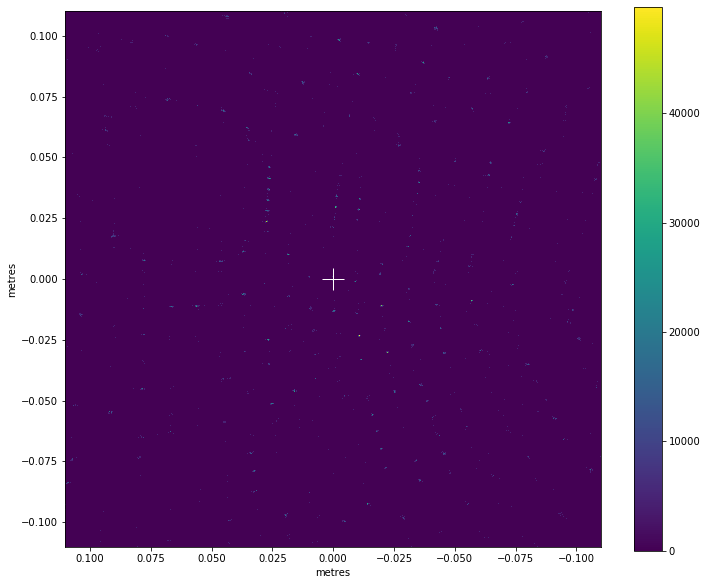

In [5]:
geom = CrystfelGeom.from_crystfel_geom('tmp.geom')
frame = f['data/0000001/data'][:]
fig, ax = plt.subplots(figsize=(12, 10))
geom.plot_data_fast(frame[np.newaxis], axis_units='m', ax=ax);

## Running CrystFEL

In [6]:
with open('test.lst', 'w') as f:
    f.write(f'{data_file}\n')

In [7]:
%%bash
source /usr/share/Modules/init/bash
module load exfel exfel_crystfel

time indexamajig -i test.lst -g tmp.geom -o out.stream --peaks=zaef

 - EXFEL modulepath enabled
Using version 1.10.4 of HDF5
Using version 1.17 of DirAx
Using XDS BUILT 20180126
Unrecognised field 'px'
Unrecognised field 'py'
Unrecognised field 'pix_width'
Unrecognised field 'd'
No indexing methods specified.  I will try to automatically detect the available methods.
To disable auto-detection of indexing methods, specify which methods to use with --indexing=<methods>.
Use --indexing=none to disable indexing and integration.
No reference unit cell provided.
List of indexing methods:
   0: asdf-nolatt-nocell        (asdf - no prior information)
Indexing parameters:
                  Check unit cell parameters: off
                        Check peak alignment: on
                   Refine indexing solutions: on
 Multi-lattice indexing ("delete and retry"): off
                              Retry indexing: on
Error: Data path ends with a / symbol
  18 indexable out of   18 processed (100.0%),   18 crystals so far.   18 images processed since the last messa

## Identified peaks

In [8]:
def read_stream_table(fh, end_marker):
    buf = io.StringIO()
    for line in fh:
        if line.startswith(end_marker):
            buf.seek(0)
            return pd.read_fwf(buf)
        
        buf.write(line)

In [9]:
stream_chunks = {}

with open('out.stream', 'r') as f:
    in_peaks_table = False
    chunk_data = {}
    for line in f:
        if '-- Begin chunk --' in line:
            chunk_data = {}
        elif '-- End chunk --' in line:
            if 'event' in chunk_data:
                stream_chunks[chunk_data['event']] = chunk_data
        
        elif line.startswith('Event:'):
            chunk_data['event'] = line.split(':', 1)[1].strip()
        
        elif line.startswith('Peaks from peak search'):
            chunk_data['peaks'] = read_stream_table(f, 'End of peak list')

In [10]:
peak_tbl = stream_chunks['0000001//']['peaks']

In [11]:
module_no = np.zeros(len(peak_tbl), dtype=np.uint32)
peak_coords = geom.data_coords_to_positions(module_no, peak_tbl['ss/px'], peak_tbl['fs/px'])
peak_x = peak_coords[:, 0]
peak_y = peak_coords[:, 1]

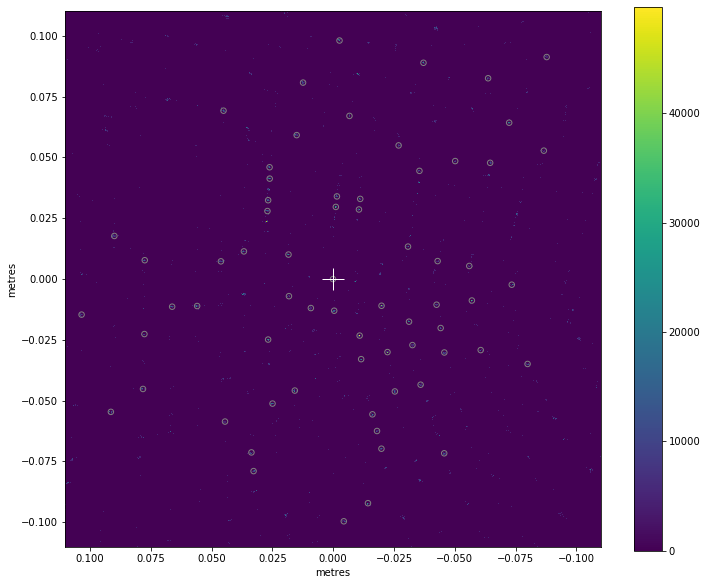

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
geom.plot_data_fast(frame[np.newaxis], axis_units='m', ax=ax)
ax.scatter(peak_x, peak_y, s=30, marker='o', facecolor='none', edgecolor='0.5');

## Examine unit cell parameters

In [13]:
from CrystFEL_Jupyter_utilities.stream_read import search_crystals_parameters

In [14]:
params_lst = search_crystals_parameters('out.stream')
params = pd.DataFrame(params_lst).drop(columns='name').rename(columns={'alfa': 'alpha'})
params

,a,b,c,alpha,beta,gamma,centering,lattice_type,unique_axis
0,38.071282,78.887988,78.976084,89.822055,90.063806,90.135002,P,triclinic,?
1,38.030696,78.908772,78.996151,90.022189,89.983891,90.003045,P,triclinic,?
2,37.987301,78.968535,78.970516,90.190316,90.003275,89.789015,P,triclinic,?
3,38.012678,78.929017,78.995467,90.141586,90.013896,89.982137,P,triclinic,?
4,38.005367,78.954010,79.044610,90.045065,89.901781,90.062258,P,triclinic,?
...,...,...,...,...,...,...,...,...,...
195,37.988565,79.166326,78.921123,90.086312,90.065187,90.034618,P,triclinic,?
196,38.039911,79.101091,78.864094,90.104502,89.907264,89.805083,P,triclinic,?
197,38.016699,78.956023,78.954766,89.956517,90.002694,89.807689,P,triclinic,?
198,37.989285,79.043379,78.941187,89.896852,90.002756,89.979023,P,triclinic,?


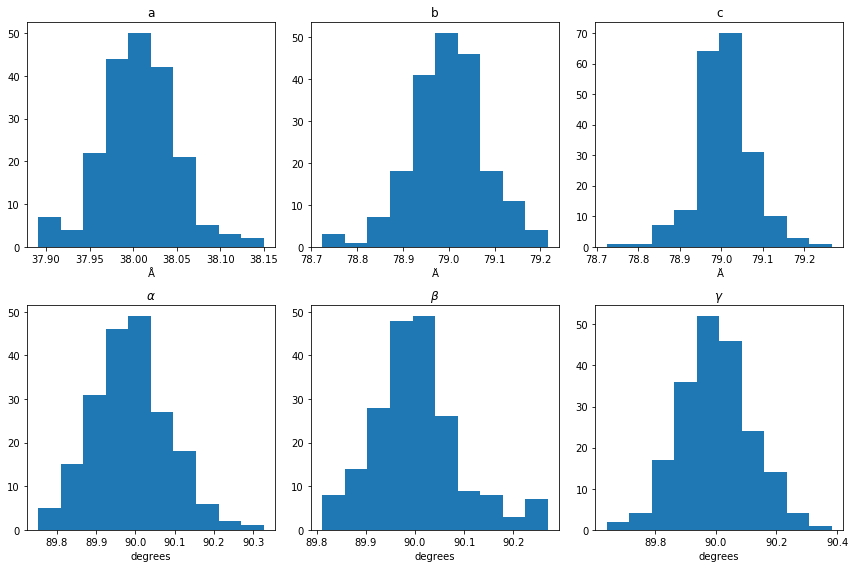

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for name, ax in zip('abc', axes[0]):
    ax.set_title(name)
    ax.set_xlabel("Å")
    ax.hist(params[name])

for name, ax in zip(('alpha', 'beta', 'gamma'), axes[1]):
    ax.set_title(f"$\\{name}$")
    ax.set_xlabel('degrees')
    ax.hist(params[name])

fig.tight_layout()

### Estimate unit cell parameters

We can estimate the value of each parameter by fitting a normal distribution to it:

In [16]:
from scipy.stats import norm

In [17]:
def plot_param(name, ax, units):
    data = params[name]
    ax.set_xlabel(units)
    ax.hist(data, density=True, color='0.8')
    
    μ, σ = norm.fit(data)
    ax.text(0.05, 0.95, f"μ = {μ:.04}, σ = {σ:.03}",
            transform=ax.transAxes, fontsize=12)
    x = np.linspace(data.min(), data.max())
    ax.plot(x, norm.pdf(x, μ, σ), linestyle='--')

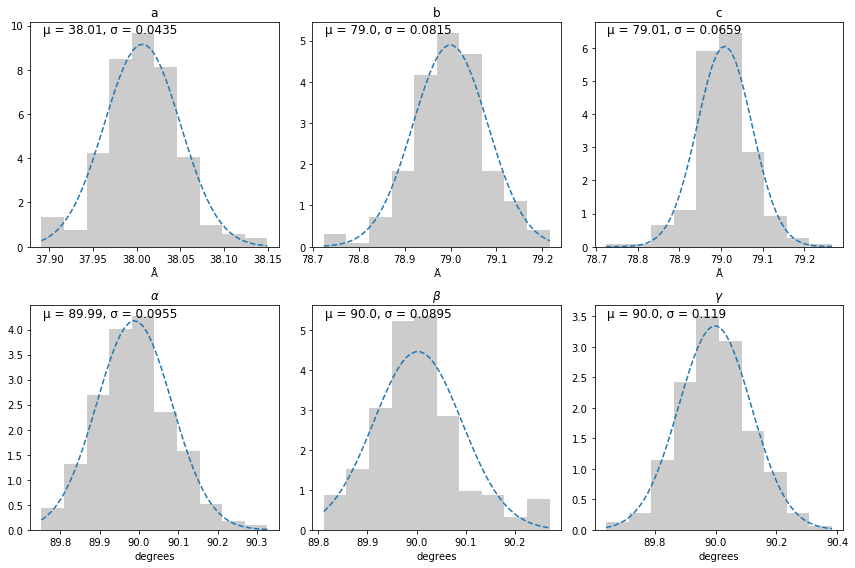

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for name, ax in zip('abc', axes[0]):
    plot_param(name, ax, "Å")
    ax.set_title(name)
    

for name, ax in zip(('alpha', 'beta', 'gamma'), axes[1]):
    plot_param(name, ax, 'degrees')
    ax.set_title(f"$\\{name}$")

fig.tight_layout()